# Capítulo 7 - Regressão Linear Simples

A saber:

- O que é uma regressão linear simples e para o que serve;
- Distinguir a variável dependente da independente;
- Como calcular uma regressão linear simples;
- Importância e cálculo da inclinação, intercept, $r^2$;
- Teste de hipótese de inclinação ser diferente de 0

**Há funções novas**

In [2]:
import plotly.express as px
import yfinance as yf
import pandas as pd

from scipy import stats
import numpy as np

def merge_time_series(df_1, df_2, how='outer'):
    df = df_1.merge(df_2, how=how, left_index=True, right_index=True)
    return df

def normalize(df):
    df = df.dropna()
    return (df / df.iloc[0]) * 100

def download_yahoo_data(tickers, normalize_quotes=True,
                      start='1970-01-01', end='2030-12-31'):
    quotes=pd.DataFrame()
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, progress=False)
        df = df[['Adj Close']]
        df.columns=[ticker]
        quotes = merge_time_series(quotes, df)

    quotes = quotes.ffill()

    if normalize_quotes:
        quotes = normalize(quotes)

    return quotes

def compute_g(FV, PV, N):
    g = ((FV/PV)**(1/N))-1
    return g

def compute_diference_in_years(start, end):
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    difference  = end_date - start_date
    difference_in_years = (difference.days)/365.2421
    return difference_in_years

def compute_FV_lump_sum(PV, r, N):
    '''
    FV = Future value / valor futuro
    PV = Present value / Valor presente
    r = Interest rate rate / Taxa de juro
    N = Número de períodos de capitalização
    '''
    FV = PV * (1+r)**N
    return FV

def compute_regression_coeficients(x, y):
    return stats.linregress(x=x, y=y)

def compute_regression_value(x, y, x_value):
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    return slope * x_value + intercept

def compute_regression_line(x, y):
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    def compute_regression_value_helper_function(x):
        return slope * x + intercept

    return list(map(compute_regression_value_helper_function, x))

def create_regression_dataframe(x, y):
    regression_line = compute_regression_line(x, y)
    df = pd.DataFrame()

    df['Y'] = list(y)
    df['X'] = list(x)
    df['Regression'] = list(regression_line)

    return df

def compute_coefficient_of_determination(squares_reg, sum_squares_total):
    '''
    squares regression/sum of squares total
    '''
    return squares_reg/sum_squares_total

def compute_std_error_reg(mean_squared_error):
    return np.sqrt(mean_squared_error)

## Exemplo de Regressão linear nos mercados a longo prazo

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/StocksForTheLongRun.PNG)

**Fonte:** Stocks for the Long Run by Jeremy J. Siegel (Sixth Edition)

Em análise financeira por vezes percisamos de de verificar se uma variável é útil para explicar outra variável. Se, por exemplo, a valorização da cotação do petróleo tem impacto na valorização de da cotação de uma empresa petrolífera, e se sim em média qual é o impacto esperado. Resumindo se o petróleo subir 1% qual o impacto esperado na cotação da empresa.

Mas isso só se pode calcular se houver uma relação entre as variáveis (neste caso a variação da cotação do petróleo e a cotação da empresa petrolífera).



## Exemplo do Livro (Exhibit 2 página 529)

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/Exhibit_2_529_1.PNG)

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/Exhibit_2_529_2.PNG)

Um analista acredita que o CAPEX do ano anterior têm impacto na variável ROA e decide testar isso. Qual a variável dependente e independente?

In [3]:
df = pd.DataFrame()

df['Y'] = [6.0, 4.0, 15.0, 20.0, 10.0, 20.0]
df['X'] = [0.7, 0.4, 5.0, 10.0, 8.0, 12.5]

df

Y     X
0   6.0   0.7
1   4.0   0.4
2  15.0   5.0
3  20.0  10.0
4  10.0   8.0
5  20.0  12.5

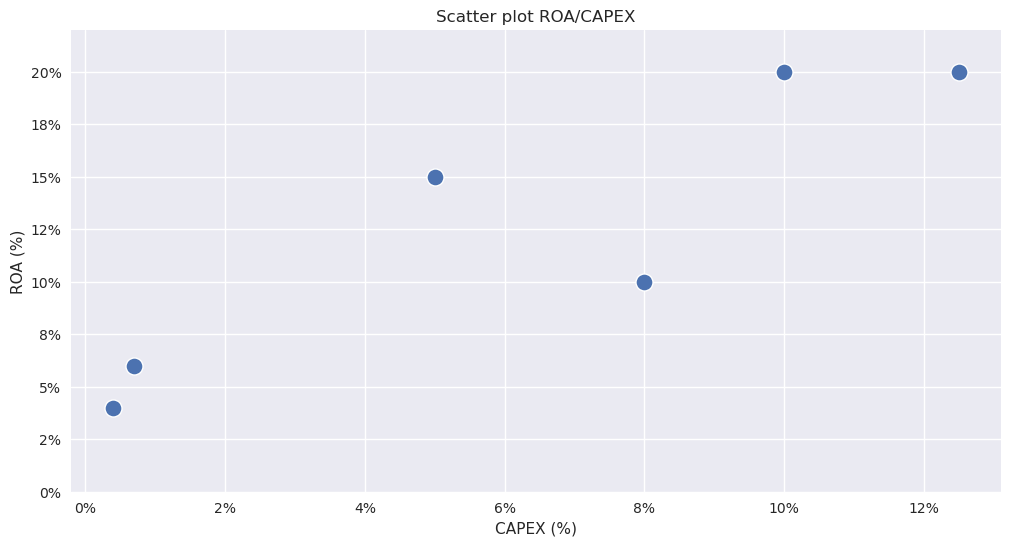

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# Set the plot size
plt.figure(figsize=(12, 6))

# Create the scatter plot
sns.scatterplot(data=df, x='X', y='Y', s=150)  # 's' sets the marker size (adjusted to be larger)

# Set plot titles and labels
plt.title("Scatter plot ROA/CAPEX")
plt.xlabel("CAPEX (%)")
plt.ylabel("ROA (%)")

# Customize the y-axis range and add percentage formatting to both axes
plt.ylim(0, 22)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Show the plot
plt.show()

### Estimação da regressão linear simples

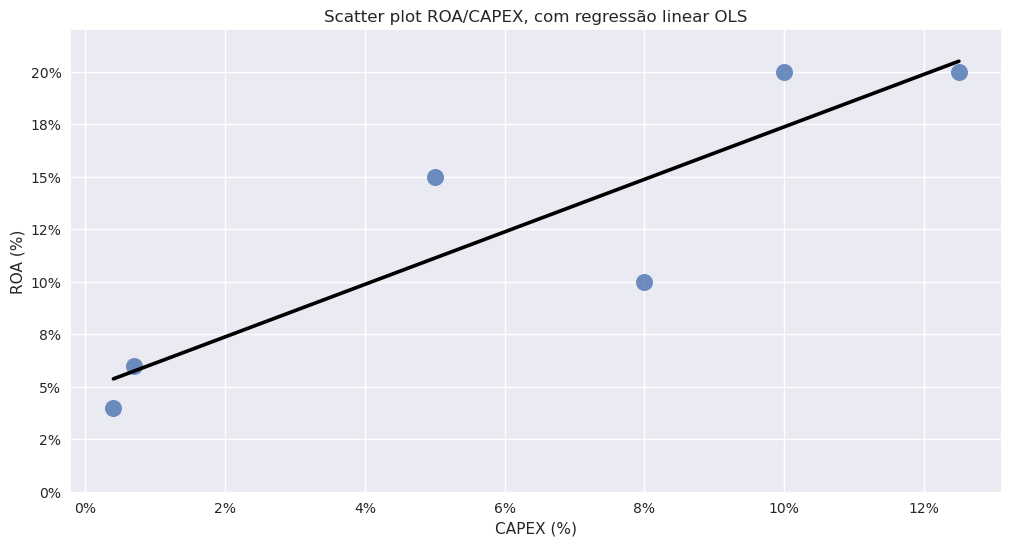

In [24]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Create the scatter plot with a regression line
sns.regplot(
    data=df, 
    x='X', 
    y='Y', 
    scatter_kws={'s': 150},  # Increase marker size
    line_kws={'color': 'black'},  # Trendline color
    ci=None  # Removes confidence interval shading, similar to Plotly's OLS trendline
)

# Set plot titles and labels
plt.title("Scatter plot ROA/CAPEX, com regressão linear OLS")
plt.xlabel("CAPEX (%)")
plt.ylabel("ROA (%)")

# Customize the y-axis range and add percentage formatting to both axes
plt.ylim(0, 22)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Show the plot
plt.show()

A recta é onde o somatório do quadrado das distâncias para a média é menor. No gráfico podemos ver os resíduos.

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/ResidualsoftheLinearRegression.PNG)

In [6]:
## PYTHON QUE TEM DE SE SABER
y = [6.0, 4.0, 15.0, 20.0, 10.0, 20.0]
x = [0.7, 0.4, 5.0, 10.0, 8.0, 12.5]

create_regression_dataframe(y=y, x=x)

Y     X  Regression
0   6.0   0.7       5.750
1   4.0   0.4       5.375
2  15.0   5.0      11.125
3  20.0  10.0      17.375
4  10.0   8.0      14.875
5  20.0  12.5      20.500

### Interpretação dos coeficientes da regressão

In [7]:
## PYTHON QUE TEM DE SE SABER
compute_regression_coeficients(x=df['X'], y=df['Y'])

LinregressResult(slope=1.25, intercept=4.874999999999999, rvalue=0.894485541601211, pvalue=0.01611258928781205, stderr=0.31239805904148915, intercept_stderr=2.3719633958885398)

### Slope - Inclinação da recta

- Positiva, variáveis têm relação positiva
- Negativa, variáveis têm relação negativa
- Próxima de 0, variáveis não têm relação

### Intercept

- Valor de Y quando X=0

### Rvalue - Força da relação

- Costuma-se usar o R^2 que é o coeficiente de determinação

> **"Expressa a quantidade da variância dos dados que é explicada pelo modelo linear. Assim, quanto maior o R², mais explicativo é o modelo linear, ou seja, melhor o modelo ajusta à amostra. Por exemplo, um R² = 0,8234 significa que o modelo linear explica 82,34% da variância da variável dependente a partir do regressores (variáveis independentes) incluídas naquele modelo linear. "*

## Previsões

Sabendo o slope e a interception podemos fazer a recta, usando qualquer valor de x na equação da mesma:

$y = mx + b$

Isso faz com que também possamos fazer estimativas ou previsões, onde seja, onde estaria a recta para um determinado valor de $x$

In [8]:
1.25 * 5 + 4.875

11.125

In [9]:
## PYTHON QUE TEM DE SE SABER
compute_regression_value(x=x, y=y, x_value=5)

11.125

In [10]:
# Onde estaria a recta para todos os valores de x entre 0 e 20?
for x_value in range(20):
  print(compute_regression_value(x=x, y=y, x_value=x_value))

4.874999999999999
6.124999999999999
7.374999999999999
8.625
9.875
11.125
12.375
13.625
14.875
16.125
17.375
18.625
19.875
21.125
22.375
23.625
24.875
26.125
27.375
28.625


### Exemplo 3 (página 539)

Um analista estimou um modelo de regressão entre o retorno sobre o patrimônio líquido de uma empresa (ROE) contra suas oportunidades de crescimento (GO), definidas como a taxa de crescimento anual composto de três anos da empresa em vendas, ao longo de 20 anos e estima a seguinte regressão linear simples:

$ROEi = 4 + 1.8 GOi + εi$
.
Ambas as variáveis ​​são expressas em percentagens, por isso uma observação GO de 5% é 5.

**1** - O valor previsto do ROE da empresa se seu GO for 10% é o mais próximo de:
- A) 1,8%
- B) 15,8%
- C) 22,0%

**2** A mudança no ROE para uma mudança no GO de 5% para 6% é mais próxima de:
- A) 1,8%
- B) 4,0%
- C) 5,8%

**3** O residual no caso de um GO de 8% e um ROE observado de 21% é
mais perto de:
- A) -1,8%
- B) 2,6%
- C) 12,0%

**Soluções**

In [11]:
# C está correta. O valor previsto do ROE = 4 + (1,8 × 10) = 22.
# A está correta. O coeficiente de inclinação de 1,8 é a mudança esperada na variável dependente (ROE) para uma mudança de uma unidade na variável independente (GO).
# B está correta. O valor previsto é ROE = 4 + (1,8 × 8) = 18,4. O valor observado do ROE é 21, portanto, o residual é 2,6 = 21,0 − 18,4.

## Presupostos do modelo de regressão linear simples

**1.** *Linearidade* - A Relação entre a variável dependente, Y, e a variável independente, X, é linear;

**2.** *Homocedasticidade* - A vâriancia para  os resíduos da regressão é constante;

**3.** *Independência*  - As observações são independentes

**4.** *Normalidade* - Os resíduos da regressão são normalmente distribuidos

### Pressuposto 1 - Linearidade

O modelo de regressão linear simples é um modelo linear por isso estamos a assumir uma relação linear entre as variáveis. Nem todas as variáveis têm uma relação linear. Um exemplo comum disso é uma relação exponencial.

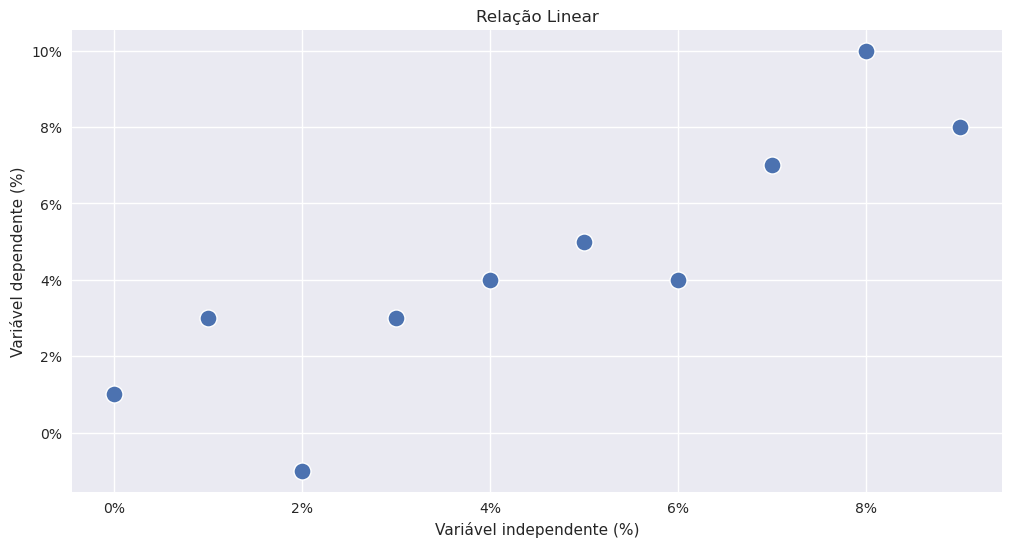

In [25]:
# Create the DataFrame
df = pd.DataFrame()
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = x + np.random.randint(-3, 3, 10)
df['X'] = x
df['Y'] = y

# Set the plot size
plt.figure(figsize=(12, 6))

# Create the scatter plot
sns.scatterplot(data=df, x='X', y='Y', s=150)  # 's' sets the marker size (adjusted to be larger)

# Set plot titles and labels
plt.title("Relação Linear")
plt.xlabel("Variável independente (%)")
plt.ylabel("Variável dependente (%)")

# Customize the axes to show percentage signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Show the plot
plt.show()


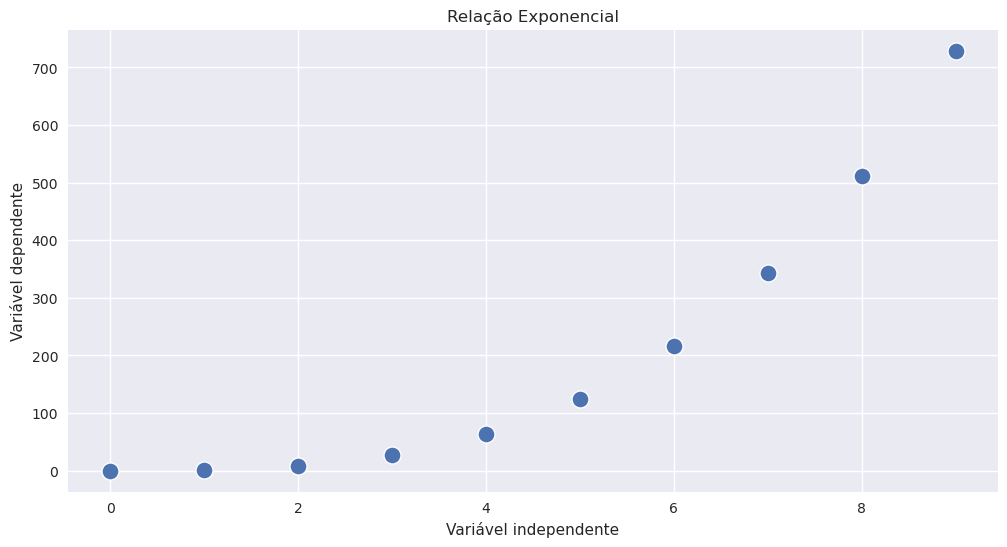

In [26]:
# Create the DataFrame
df = pd.DataFrame()
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = x ** 3
df['X'] = x
df['Y'] = y

# Set the plot size
plt.figure(figsize=(12, 6))

# Create the scatter plot
sns.scatterplot(data=df, x='X', y='Y', s=150)  # 's' sets the marker size (adjusted to be larger)

# Set plot titles and labels
plt.title("Relação Exponencial")
plt.xlabel("Variável independente")
plt.ylabel("Variável dependente")

# Show the plot
plt.show()

### Pressuposto 2 - Homocedasticidade dos resíduos

Uma análise entre taxa de juro de curto prazo e inflação. Podemos criar um modelo entre estas duas variáveis e se a análise tiver muitos anos podemos na realidade encontrar diferentes "períodos". Diferentes lideranças do bancos centrais (assim como diferentes estados económicos) podem ter levado a um ["regime shift"](http://appinsys.com/globalwarming/ClimateRegimeShift_files/image001.jpg) que vai invalidar uma análise que inclua todo o tempo.

É como se houvesse dois modelos diferentes. Um mais antigo e outro mais recente.

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/ScatterPlotofInterestRatesandInflationRates.PNG)



A variância dos resíduos neste caso é heterocedástica

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/ResidualPlotforInterestRatesInflationRates.PNG)



![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/FittedRegressionLineForTheTwoRegimes.PNG)

(Exemplo na página 542)

### Pressuposto 3: Independência

Assumimos que as observações (pares Y e X) não estão correlacionadas entre si,
ou seja, são independentes. Se houver correlação entre as observações (ou seja,
autocorrelação), eles não são independentes e os resíduos serão correlacionados.



#### Autocorrelações dos retornos mensais do CSPX

In [14]:
tickers = ['CSPX.AS']
start = '2011-12-30'
end = '2021-12-31'

# Download das cotações
ETFs = download_yahoo_data(tickers=tickers, normalize_quotes=True, start=start, end=end)

# Fazer dataframe de retornos
ETFs_ret=ETFs.resample('M').last().pct_change().dropna() * 100

/tmp/ipykernel_157732/1727988276.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



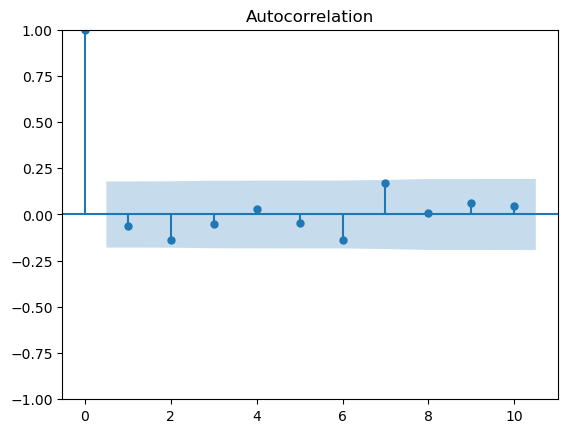

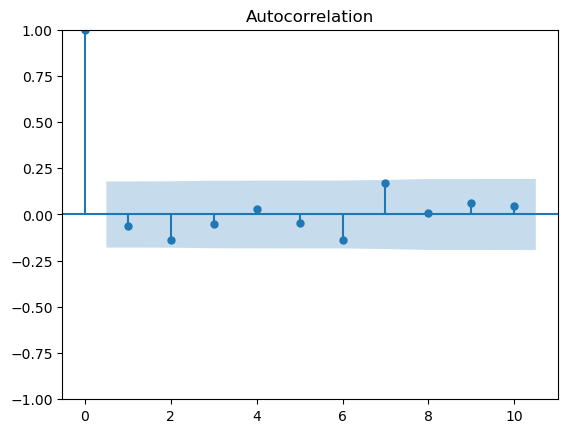

In [15]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(ETFs_ret['CSPX.AS'], lags=10)

### Pressuposto 4 - Normalidade

Estamos a assumir que os resíduos são normalmente distribuídos.

## Qualidade do modelo

### Coeficiente de determinação ou $r^2$

O $r^2$ é a percentagem da variação da variável independente que é explicado pela variável independente.

**Exemplo com o ROA /CAPEX que fizemos acima (página 548)**

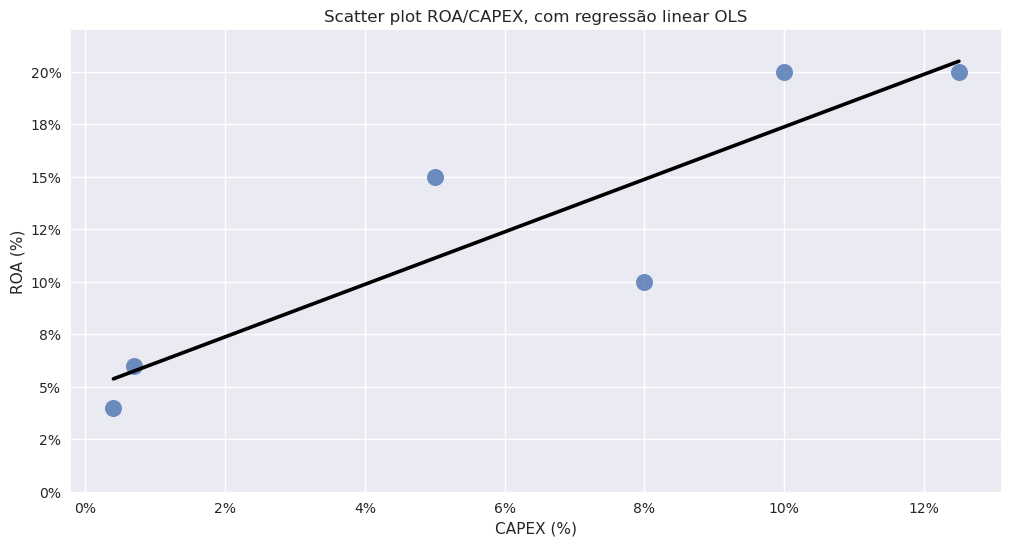

In [28]:
# Create the DataFrame
df = pd.DataFrame()
df['Y'] = [6.0, 4.0, 15.0, 20.0, 10.0, 20.0]
df['X'] = [0.7, 0.4, 5.0, 10.0, 8.0, 12.5]

# Set the plot size
plt.figure(figsize=(12, 6))

# Create the scatter plot with a regression line
sns.regplot(
    data=df, 
    x='X', 
    y='Y', 
    scatter_kws={'s': 150},  # Marker size
    line_kws={'color': 'black'},  # Trendline color
    ci=None  # Removes the confidence interval to mimic OLS trendline
)

# Set plot titles and labels
plt.title("Scatter plot ROA/CAPEX, com regressão linear OLS")
plt.xlabel("CAPEX (%)")
plt.ylabel("ROA (%)")

# Customize the y-axis range and add percentage formatting to both axes
plt.ylim(0, 22)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Show the plot
plt.show()


Calcular coeficientes

No resultado temos o rvalue. Por sua vez o $R^2$ é naturalmente esse valor elevado ao quadrado.

In [17]:
# Python a saber
Y = [6.0, 4.0, 15.0, 20.0, 10.0, 20.0]
X = [0.7, 0.4, 5.0, 10.0, 8.0, 12.5]
compute_regression_coeficients(x=X, y=Y)

LinregressResult(slope=1.25, intercept=4.874999999999999, rvalue=0.894485541601211, pvalue=0.01611258928781205, stderr=0.31239805904148915, intercept_stderr=2.3719633958885398)

In [18]:
0.894485541601211**2

0.8001043841336117

Um $r^2$ elevado normalmente significa que, pelo menos inicialmente, o modelo é explicativo. Olhando para os gráficos uma gráfico onde a linha de regressão linear é inclinada terá um $R^2$ elevado e se for horizontal terá um $R^2$ baixo, o que significa que o modelo não tem capacidade explicativa ou preditiva.

#### Fórmula a saber sobre o coeficiente de determinação

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/FormulaCoeficienteDeterminacao.PNG)

Porque muitas vezes só têm acesso à Sum of Square regression e à sum of square total. Criei função compute_coefficient_of_determination só para se lembrarem. Vamos usar esta função para resolver exercícios.



### Erro Padrão

O erro padrão é medida da distância entre os valores observados da variável dependente e aquelas previstas a partir da regressão estimada; quanto menor o
erro padrão melhor o ajuste do modelo.

**Exercício** (Exemplo 5 página 551)

![](https://s3.us-east-2.amazonaws.com/cbs.pg.repository/img/AnovaTable_5_551.PNG)

- **1.** Calcule o coefficiente de determinação deste modelo de regressão?
- **2.** Qual é o erro padrão da estimativa para este modelo de regressão?

In [19]:
# squares regression/sum of squares total

compute_coefficient_of_determination(576.1485, 2449.7100)

0.23519049193578015

In [20]:
compute_std_error_reg(19.1180)

4.372413521157394